In [1]:
import os
import cv2
import numpy as np
import random
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, GRU, Bidirectional, TimeDistributed
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, Activation, BatchNormalization, Subtract, Multiply, Add, Concatenate
import pywt
from pywt import dwt2,idwt2
import PIL.Image as Image

In [2]:
TESTDIR ="C:\\Users\\zesha\\Desktop\\Urban100\\"
MODEL = "C:\\Users\\zesha\\Desktop\\WEIGHTS_WAVELET\\149.1\\model_checkpoint.h5"
saved_model = load_model(MODEL)
saved_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256)]   0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose (TFOpLam (None, 256, 256)     0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256, 256)     789504      tf.compat.v1.transpose[0][0]     
__________________________________________________________________________________________________
subtract (Subtract)             (None, 256, 256)     0           tf.compat.v1.transpose[0][0]     
                                                                 bidirectional[0][0]          

In [3]:
def psnr_ssim_metrics(ground_truth, predicted, degraded):
    # PSNR
    psnr_degraded = peak_signal_noise_ratio(ground_truth, degraded)
    psnr_predicted = peak_signal_noise_ratio(ground_truth, predicted)
    psnr_difference = psnr_predicted - psnr_degraded
    # SSIM
    ssim_degraded = structural_similarity(ground_truth, degraded)
    ssim_predicted = structural_similarity(ground_truth, predicted)
    ssim_difference = ssim_predicted - ssim_degraded
    return psnr_degraded, psnr_predicted, psnr_difference, ssim_degraded, ssim_predicted, ssim_difference

In [4]:
def average(lst):
    return sum(lst) / len(lst)

In [5]:
def Degrade(image, noise_val):
    beta =  noise_val*np.random.rand(1)
    image.astype('float32')    
    np.random.seed(0)
    G_col =  np.random.normal(0, beta, image.shape[1])
    G_noise = np.tile(G_col,(image.shape[0],1))
    G_noise = np.reshape(G_noise,image.shape)
               
    image_G = image + G_noise
    return image_G, G_noise

In [6]:
print("Creating Testing Data...")
testing_data = []
IMG_SIZE = 256

def create_testing_data():
    for img in os.listdir(TESTDIR):
        try: 
            img_array = cv2.imread(os.path.join(TESTDIR,img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            testing_data.append([new_array])
        except Exception as e:
            pass 

create_testing_data()  

testing_data = np.array(testing_data)
print("Testing Data Length: " + str(len(testing_data)))

Creating Testing Data...
Testing Data Length: 100


In [7]:
noise_val = 149.1

print("Degrading Testing Data...")
model_testing_data = []
clean_testing_data = []
for images in testing_data:
    model_image = Degrade(images[0],noise_val)[0]
    model_testing_data.append(model_image/255.0)
    clean_testing_data.append(images.squeeze()/255.0)
clean_testing_data = np.array(clean_testing_data)
model_testing_data = np.array(model_testing_data)
print("Degrading Testing Data... Done")

Degrading Testing Data...
Degrading Testing Data... Done


In [8]:
output = saved_model.predict(model_testing_data)

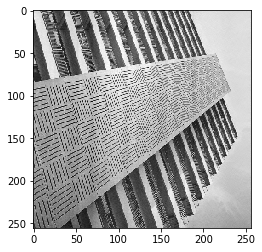

In [9]:
plt.imshow(output[91], cmap = 'gray')

In [10]:
peak_signal_noise_ratio(clean_testing_data[91], output[91])

C:\Users\zesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """Entry point for launching an IPython kernel.


28.82977440525586

In [11]:
psnr_degraded_lst = []
psnr_predicted_lst = []
psnr_difference_lst = []
ssim_degraded_lst = []
ssim_predicted_lst = []
ssim_difference_lst = []

for i in range(len(output)):
    psnr_degraded, psnr_predicted, psnr_difference, ssim_degraded, ssim_predicted, ssim_difference = \
        psnr_ssim_metrics(clean_testing_data[i], output[i], model_testing_data[i])
    psnr_degraded_lst.append(psnr_degraded)
    psnr_predicted_lst.append(psnr_predicted)
    psnr_difference_lst.append(psnr_difference)
    ssim_degraded_lst.append(ssim_degraded)
    ssim_predicted_lst.append(ssim_predicted)
    ssim_difference_lst.append(ssim_difference)

psnr_degraded_average = average(psnr_degraded_lst)
print("The average PSNR of all Test Degraded Images w.r.t Ground Truth: " + str(psnr_degraded_average))
psnr_predicted_average = average(psnr_predicted_lst)
print("The average PSNR of all Test Predicted Images w.r.t Ground Truth: " + str(psnr_predicted_average))
psnr_difference_average = average(psnr_difference_lst)
print("The average PSNR Difference: " + str(psnr_difference_average))

ssim_degraded_average = average(ssim_degraded_lst)
print("The average SSIM of all Test Degraded Images w.r.t Ground Truth: " + str(ssim_degraded_average))
ssim_predicted_average = average(ssim_predicted_lst)
print("The average SSIM of all Test Predicted Images w.r.t Ground Truth: " + str(ssim_predicted_average))
ssim_difference_average = average(ssim_difference_lst)
print("The average SSIM Difference: " + str(ssim_difference_average))

C:\Users\zesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  after removing the cwd from sys.path.
C:\Users\zesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  


The average PSNR of all Test Degraded Images w.r.t Ground Truth: 16.367677225092763
The average PSNR of all Test Predicted Images w.r.t Ground Truth: 28.242799201930676
The average PSNR Difference: 11.875121976837889
The average SSIM of all Test Degraded Images w.r.t Ground Truth: 0.555681261754096
The average SSIM of all Test Predicted Images w.r.t Ground Truth: 0.9712567970676844
The average SSIM Difference: 0.4155755353135885


In [12]:
init = 'he_normal'

def SNRDWNN():
    
    inpt = Input(shape=(None,None,4))
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same' ,kernel_initializer=init,name='Conv-1')(inpt)
    x = Activation('relu')(x)
    for i in range(8):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same' ,kernel_initializer=init)(x)
        x = Activation('relu')(x)
    residual = Conv2D(filters=4, kernel_size=(3,3), strides=(1,1), padding='same' ,kernel_initializer=init, name = 'residual')(x)
    res = Add(name = 'res')([inpt,residual])
    model = Model(inputs=inpt, 
                  outputs=[res,residual],
                  name = 'DWSRN'
                  )
    
    return model

In [13]:
WAVELET_DIRECTORY =  "C:\\Users\\zesha\\Desktop\\WEIGHTS_WAVELET\\weights_0.15.hdf5"
model = SNRDWNN()
model.load_weights(WAVELET_DIRECTORY)
model.summary()

Model: "DWSRN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv-1 (Conv2D)                 (None, None, None, 6 2368        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 6 0           Conv-1[0][0]                     
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 36928       activation[0][0]                 
______________________________________________________________________________________________

In [14]:
model =  SNRDWNN()
model.load_weights(WAVELET_DIRECTORY)         
name = []
GainList = []
OnoiseList = []
psnr = []
ssim = []
psnr_noise_lst = []
ssim_noise_lst = []
clean_images = []
cnt=0
clean_wavelet_images = []

for i in range(100):
    img_test = model_testing_data[i]
    img_clean = clean_testing_data[i]
    # predict
    x_test = np.expand_dims(img_test,axis=0)
    x_test = np.expand_dims(x_test,axis=3)                

    # Descreat Wavelet Transform
    t1 = time.time()
    LLY,(LHY,HLY,HHY) = pywt.dwt2(img_test, 'haar')
    Y = np.stack((LLY,LHY,HLY,HHY),axis=2)
    # predict
    x_test = np.expand_dims(Y,axis=0)
    y_pred,noise = model.predict(x_test)
    # calculate numeric metrics

    coeffs_pred = y_pred[0,:,:,0],(LHY,y_pred[0,:,:,2],HHY)

    img_out = pywt.idwt2(coeffs_pred, 'haar')
    t2 = time.time()
    print(i)
    img_out = np.clip(img_out, 0, 1)
    psnr_noise, psnr_denoised = peak_signal_noise_ratio(img_clean, img_test), peak_signal_noise_ratio(img_clean, img_out)
    ssim_noise, ssim_denoised = structural_similarity(img_clean, img_test), structural_similarity(img_clean, img_out)
    clean_wavelet_images.append(img_out)
    psnr.append(psnr_denoised)
    ssim.append(ssim_denoised)
    psnr_noise_lst.append(psnr_noise)
    ssim_noise_lst.append(ssim_noise)
    clean_images.append(img_out)

psnr_avg = sum(psnr)/len(psnr)
ssim_avg = sum(ssim)/len(ssim)
psnr_noise_avg = sum(psnr_noise_lst)/len(psnr_noise_lst)
ssim_noise_avg = sum(ssim_noise_lst)/len(ssim_noise_lst)
name.append('Average')
psnr.append(psnr_avg)
ssim.append(ssim_avg)
print('Average PSNR = {0:.4f}, SSIM = {1:.4f}'.format(psnr_avg, ssim_avg))
print('Degraded PSNR = {0:.4f}, SSIM = {1:.4f}'.format(psnr_noise_avg, ssim_noise_avg))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Average PSNR = 25.0520, SSIM = 0.9437
Degraded PSNR = 16.3677, SSIM = 0.5557


In [15]:
psnr_reduced = psnr[0:100]
len(psnr_reduced)

100

In [16]:
len(psnr_predicted_lst)

100

In [17]:
list = [x1 - x2 for (x1, x2) in zip(psnr_predicted_lst, psnr_reduced)]

In [18]:
list

[9.433791008229715,
 5.6852459114826,
 1.8393790234515102,
 2.2360865385076636,
 2.1783677860998942,
 1.417783781503612,
 3.9125344577259433,
 2.8645776076528406,
 1.0249844669915014,
 4.55113163582708,
 5.358393193013711,
 2.6870227199357224,
 2.600737077363007,
 5.850381983338934,
 4.900573690790324,
 5.087003583336433,
 3.1101103450412992,
 1.158191418182323,
 2.8080921351138883,
 2.8163121445138835,
 -0.8914978314377606,
 7.748416518335937,
 3.158014632815558,
 4.193346737337848,
 0.9343826958971881,
 3.377558930818129,
 5.5642363107514505,
 2.5276067062060683,
 2.6443980229327373,
 2.210499540101033,
 3.2191265871380885,
 1.676697918849321,
 3.5215043714144905,
 1.8338068597477921,
 0.09187737466528034,
 3.7715892924868157,
 2.1642474109781986,
 4.187230622032168,
 4.989145750395064,
 0.5631460127828198,
 2.421524872929723,
 3.2801170842636864,
 -0.7878371826229653,
 5.447211179761883,
 3.558317430373549,
 4.963764502675794,
 2.226873563768706,
 3.7561974232995325,
 1.334221701906

In [19]:
list[40]

2.421524872929723

In [20]:
psnr[95]

23.428718130303544

In [21]:
psnr_predicted_lst[95]

31.463365577837884

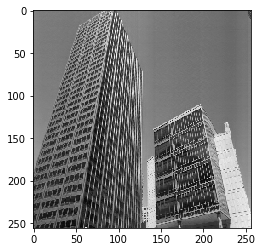

In [22]:
plt.imshow(output[95], cmap = "gray")

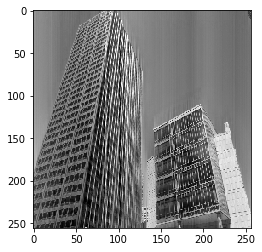

In [23]:
plt.imshow(clean_wavelet_images[95], cmap = "gray")

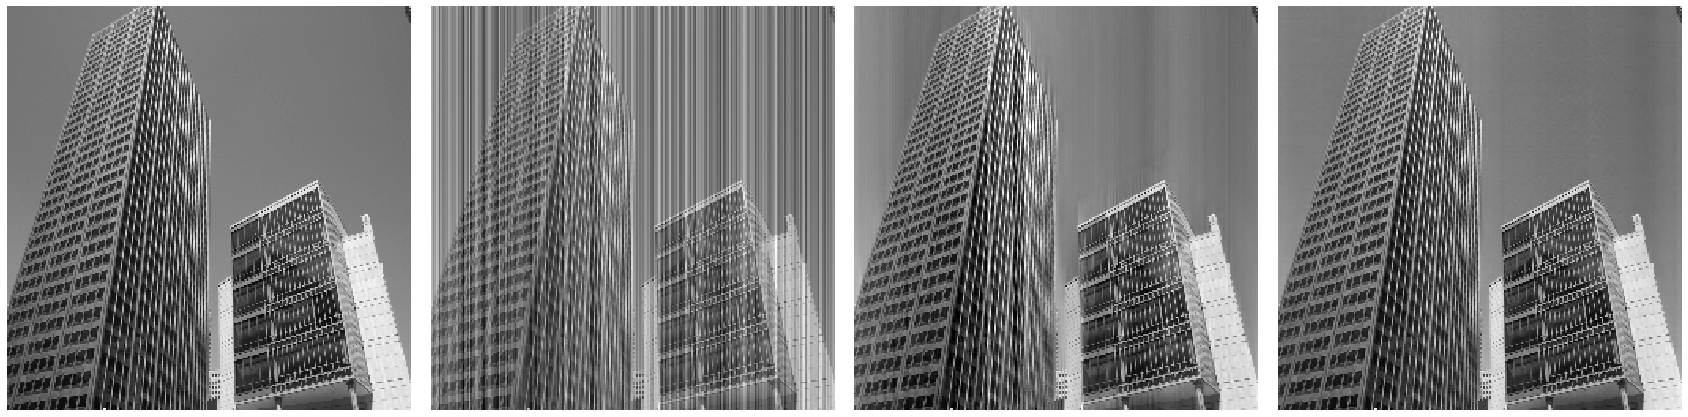

In [24]:
pltfig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey =True, figsize=(30,25))
ax1.imshow(clean_testing_data[95], cmap = "gray")

ax2.imshow(model_testing_data[95], cmap = "gray")

ax3.imshow(clean_wavelet_images[95], cmap = "gray")

ax4.imshow(output[95], cmap = "gray")

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

pltfig.subplots_adjust(wspace=0.05, hspace=0)

In [25]:
clean_testing_data[95]

array([[0.45490196, 0.45882353, 0.4627451 , ..., 0.23921569, 0.22745098,
        0.70980392],
       [0.4627451 , 0.45882353, 0.4627451 , ..., 0.20784314, 0.27058824,
        0.14509804],
       [0.46666667, 0.4627451 , 0.4627451 , ..., 0.23529412, 0.21960784,
        0.49019608],
       ...,
       [0.1254902 , 0.24705882, 0.35686275, ..., 0.8627451 , 0.8745098 ,
        0.86666667],
       [0.10980392, 0.35686275, 0.30980392, ..., 0.74509804, 0.74901961,
        0.80784314],
       [0.10980392, 0.35686275, 0.23137255, ..., 0.85490196, 0.86666667,
        0.87058824]])

In [26]:
col_val = []
for i in range(256):
    col_val.append((clean_testing_data[2])[i][3])
col = sum(col_val)/len(col_val)
col

0.36691176470588266

In [36]:
def calculateColMean(image):
    mean_values = []
    for k in range(256):
        column_values = []
        for i in range(256): #columns
            column_values.append((image[95])[i][k]) #try 87 aswell - or any other val between 0 and 100 - SPECIFICALLY 95
        column_values_mean = sum(column_values)/len(column_values)  
        mean_values.append(column_values_mean*255)
    return mean_values

In [37]:
mean_values = calculateColMean(clean_testing_data) #try 95 aswell
mean_values_wavelet = calculateColMean(clean_wavelet_images)
mean_values_ourMethod = calculateColMean(output)

C:\Users\zesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


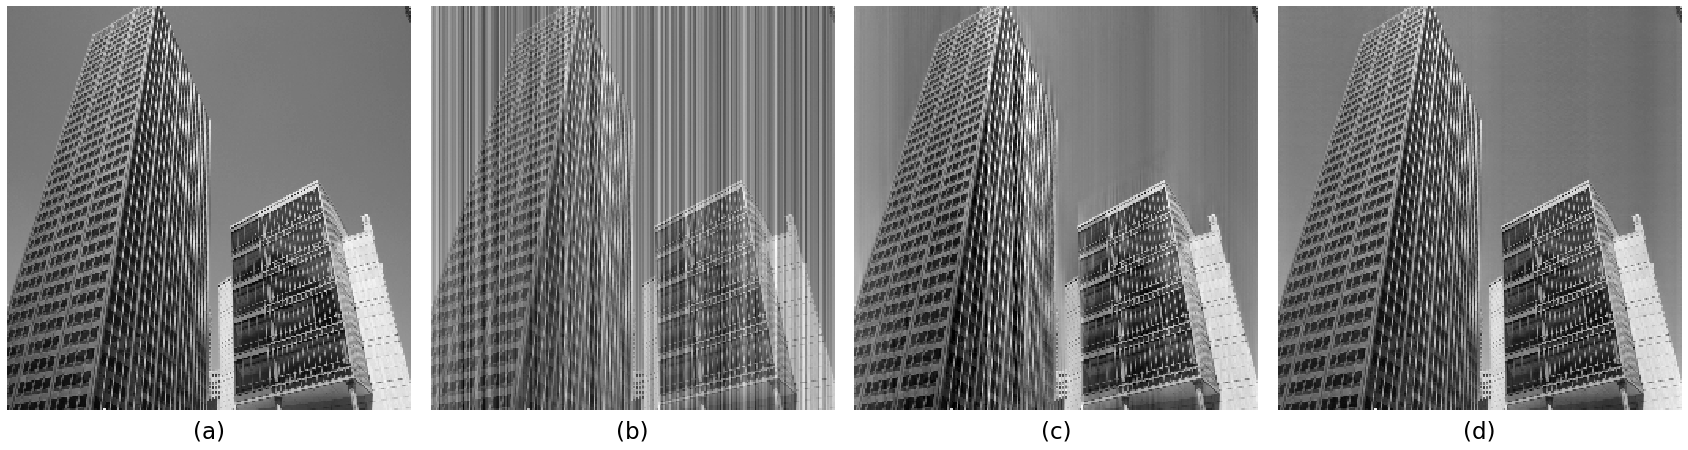

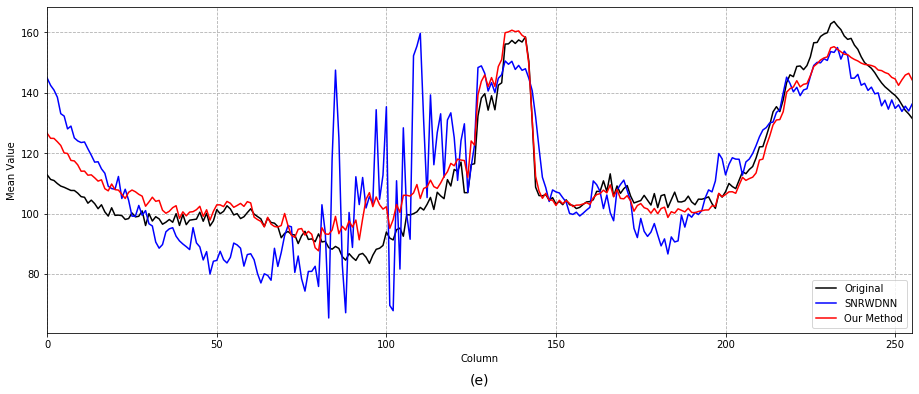

In [38]:
pltfig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey =True, figsize=(30,25))
ax1.imshow(clean_testing_data[95], cmap = "gray")
ax1.set_title('(a)', y =0, pad = -10, verticalalignment = "top", fontsize =23)

ax2.imshow(model_testing_data[95], cmap = "gray")
ax2.set_title('(b)', y =0, pad = -10, verticalalignment = "top", fontsize =23)

ax3.imshow(clean_wavelet_images[95], cmap = "gray")
ax3.set_title('(c)', y =0, pad = -10, verticalalignment = "top", fontsize =23)

ax4.imshow(output[95], cmap = "gray")
ax4.set_title('(d)', y =0, pad = -10, verticalalignment = "top", fontsize =23)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

pltfig.subplots_adjust(wspace=0.05, hspace=0)

plt.figure(figsize = (15.5,6))
plt.plot(range(256), mean_values, color = 'black')
plt.plot(range(256), mean_values_wavelet, color = 'blue')
plt.xlim(0, 255)
plt.plot(range(256), mean_values_ourMethod, color = 'red')
plt.legend(['Original', 'SNRWDNN', 'Our Method'], loc = 'lower right')
plt.xlabel('Column')
plt.ylabel('Mean Value')
plt.grid(which = 'major', linestyle = '--')
plt.title('(e)', y =0, pad = -40, verticalalignment = "top", fontsize =14)


pltfig.savefig("C:\\Users\\zesha\\Desktop\\comp.pdf")
pltfig.show()

plt.savefig("C:\\Users\\zesha\\Desktop\\col-by-col.pdf")
plt.show()


In [30]:
(clean_testing_data[95])[255][0]

0.10980392156862745

In [31]:
data = np.asarray(clean_testing_data[95])

In [32]:
data

array([[0.45490196, 0.45882353, 0.4627451 , ..., 0.23921569, 0.22745098,
        0.70980392],
       [0.4627451 , 0.45882353, 0.4627451 , ..., 0.20784314, 0.27058824,
        0.14509804],
       [0.46666667, 0.4627451 , 0.4627451 , ..., 0.23529412, 0.21960784,
        0.49019608],
       ...,
       [0.1254902 , 0.24705882, 0.35686275, ..., 0.8627451 , 0.8745098 ,
        0.86666667],
       [0.10980392, 0.35686275, 0.30980392, ..., 0.74509804, 0.74901961,
        0.80784314],
       [0.10980392, 0.35686275, 0.23137255, ..., 0.85490196, 0.86666667,
        0.87058824]])